In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.chdir("/content/drive/MyDrive/DS")

Mounted at /content/drive


In [ ]:
!pip3 install vncorenlp

# Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter) 
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/ 
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

In [1]:
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
!pip install transformers

In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from transformers import AutoModel, AutoTokenizer

phobert = AutoModel.from_pretrained("vinai/phobert-base").to(device)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
tokenizer_phobert = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/518M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/874k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 


# Load data

In [8]:
def getFeature(data):
    for x in tqdm(range(data.shape[0])):
        sentences = rdrsegmenter.tokenize(data.description.iloc[x])
        tmp = []
        for sentence in sentences:
            arr = " ".join(sentence)
            tmp.append(arr)
        data.loc[x,'des_tokens'] = ' </s> <s> '.join(tmp)
        cols = ['des_tokens']
        new_data = pd.DataFrame(data[cols])

    def converInput(newData):
        train_ids = []
        train_token = []
        train_mask = []
        for x in tqdm(range(newData.shape[0])):
            input = tokenizer_phobert.encode_plus(newData.iloc[x]['des_tokens'],padding ='max_length',max_length=150,truncation =True)
            train_ids.append(input['input_ids'])
            train_token.append(input['token_type_ids'])
            train_mask.append(input['attention_mask'])
        return train_ids,train_token,train_mask
    train_ids,train_token,train_mask = converInput(new_data)
    train_ids = torch.tensor(train_ids)
    train_token = torch.tensor(train_token)
    train_mask = torch.tensor(train_mask)
    from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
    train_data = TensorDataset(train_ids, train_token,train_mask)
    train_sampler = SequentialSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=16)
    df = []
    phobert.train()
    with torch.no_grad():
      for x, batch in tqdm(enumerate(train_dataloader)):
          train_ids = batch[0].to(device)
          train_tokens = batch[1].to(device)
          train_mask = batch[2].to(device)
          encoded_layers = phobert(train_ids, token_type_ids = train_tokens, attention_mask =train_mask)
          top_vec = encoded_layers[0]
          top_vec = top_vec[:,0,:].cpu()
          df.append(top_vec)
    tmp = torch.concat(df)
    return tmp

## train data

In [2]:
data = pd.read_csv('../Preprocess/train_data.csv')
data = getFeature(data)

F:\AnacondaPackage\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
torch.save(data,'../Model/Description/train_des.pth')

## Test data

In [3]:
data = pd.read_csv('../Preprocess/test_data.csv')
data = getFeature(data)
torch.save(data,'../Model/Description/test_des.pth')

# Analyze the number of sentences

In [3]:
import pandas as pd
from tqdm import tqdm
data = pd.read_csv('../Preprocess/train_data.csv')

F:\AnacondaPackage\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
lenDes = []
for x in tqdm(range(data.shape[0])):
    arr = data.description.iloc[x].split(' ')
    lenDes.append(len(arr))

100%|██████████| 50001/50001 [00:01<00:00, 28844.98it/s]


(array([2.970e+04, 1.519e+04, 3.532e+03, 1.219e+03, 3.220e+02, 3.200e+01,
        2.000e+00, 3.000e+00, 0.000e+00, 1.000e+00]),
 array([  6. ,  79.7, 153.4, 227.1, 300.8, 374.5, 448.2, 521.9, 595.6,
        669.3, 743. ]),
 <BarContainer object of 10 artists>)

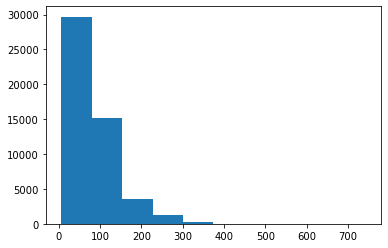

In [5]:
import matplotlib.pyplot as plt
plt.hist(lenDes,10)